# Cropping documents in an image. 

The purpose of this notebook is demonstrate how to crop a document from a photograph. 

**Author**: Simon O'Doherty.<br> 
**Note**: This notebook is totally unsupported.

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.segmentation import flood

You will need to change `loadImage` if your images don't have an alphachannel. 

In [2]:
def loadImage(file_name):
    img = cv2.imread(file_name, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB) # remove "A" if no alpha channel.
    return img

img = loadImage('example.png')

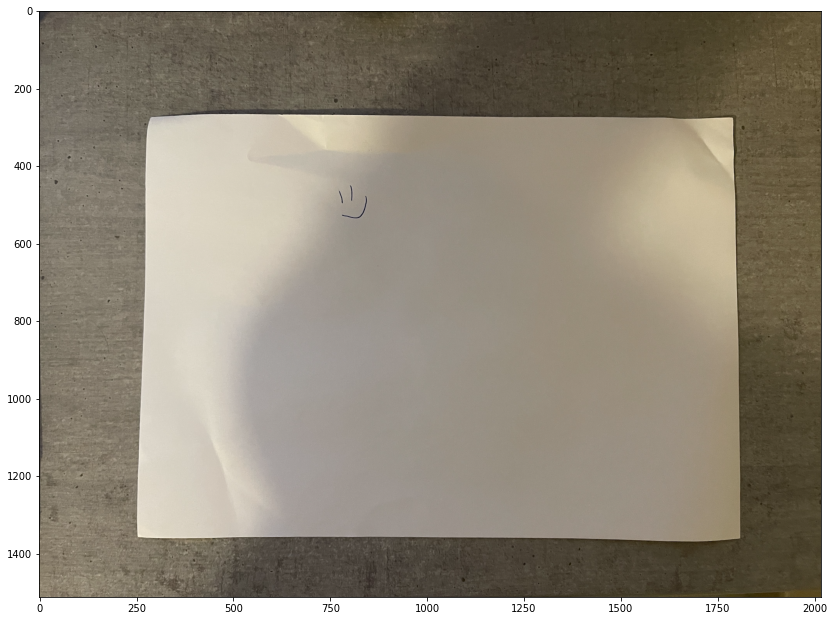

In [3]:
def showImage(img, width=14, height=14):
    plt.figure(figsize=(width, height))
    plt.imshow(img)
    plt.show()
    
showImage(img)

---
This does the following. 

- Break the image into it's R,G,B channels.
- Run the Sobel operator to detect edges in each channel. 
- Noise level is set to remove any ambient noise in the image (you may need to tinker). 
- Strongest edges are taken from all three channels to create the edge image. 
- Any remaining values below the mean value of the image are erased. 

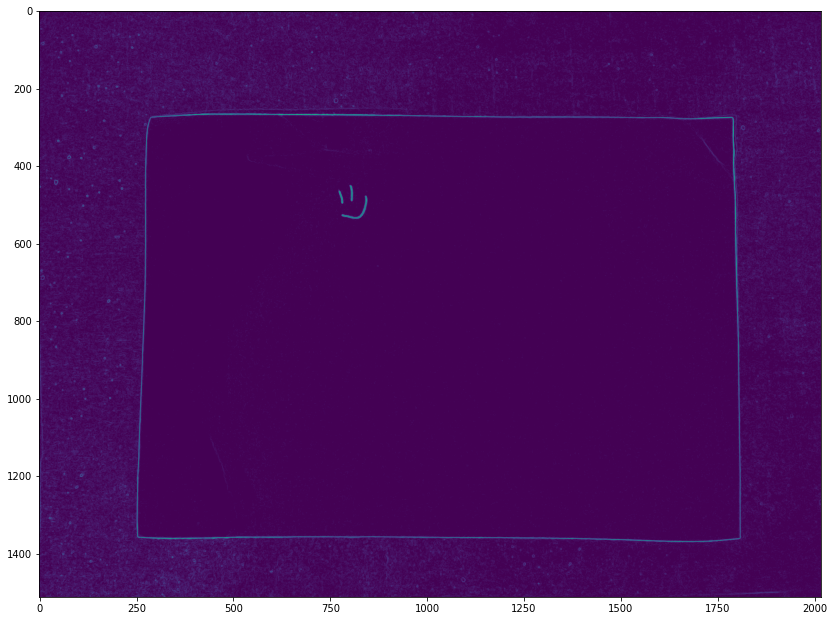

In [4]:
def edgeDetect (img, noise_level=9000):
    r, g, b = cv2.split(img)
    rgb = [r,g,b]
    e = []
    for channel in rgb:
        sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0)
        sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1)
        sobel = np.hypot(sobelX, sobelY)

        sobel[sobel > noise_level] = 255;
        e.append(sobel)
        
    edge_image = np.max(np.array([e[0], e[1], e[2]]), axis=0)
    
    mean = np.mean(edge_image);
    edge_image[edge_image <= mean] = 0;
    
    edge_image.astype(img.dtype)
    return edge_image
    
edge_image = edgeDetect(img)

showImage(edge_image)

Using the edge detection image, flood fill outside to create the image mask for the document. This done as follows. 

- Use skimage flood fill at a start point with a set tolerance (you need to tinker)
- Invert the generated fill. 
- Convert the True/False mask to a white/black color.
- Convert the colors into RGB channels. 

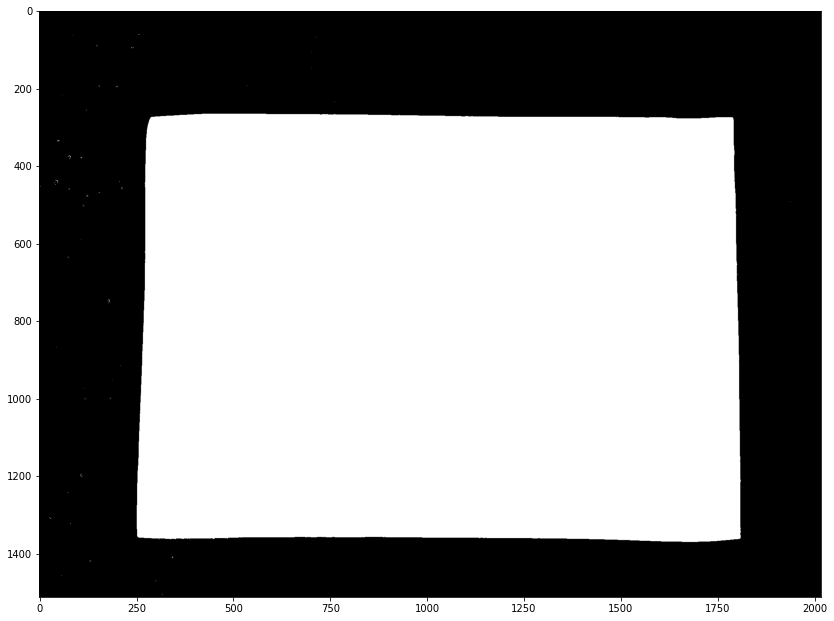

In [5]:
def createMask(image, start_point=(0,0), tolerance=294):
    
    mask = image.copy()
    mask = flood(mask, (0, 0), tolerance=tolerance)
    mask = mask != True
    mask = mask * 255
    
    mask[mask < 255] = 0;
    
    mask = cv2.merge([mask, mask, mask])
    mask = np.uint8(mask)
    mask.astype(image.dtype)
    
    return mask

mask = createMask(edge_image)

showImage(mask)

Apply the mask to the original image. 

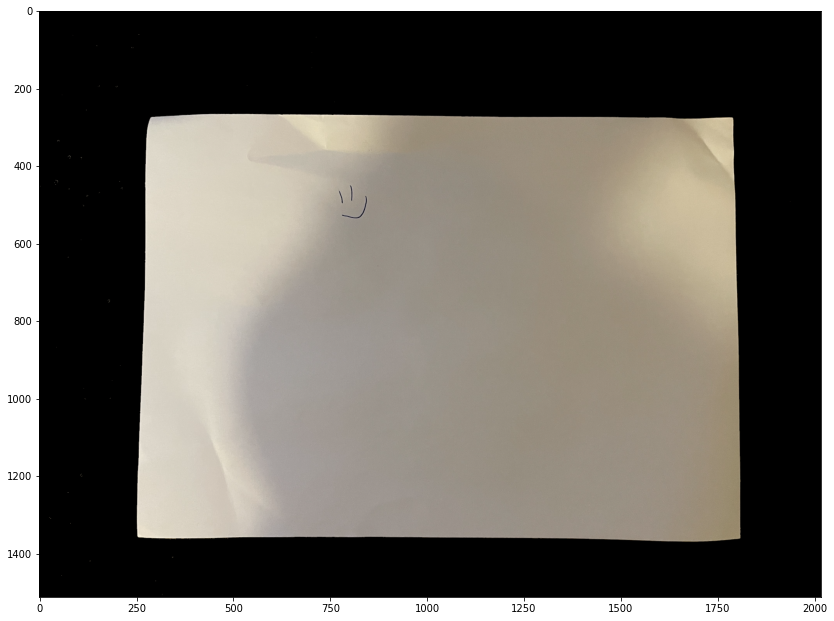

In [6]:
image2 = img.copy()
image2 = cv2.copyTo(image2, mask=mask)

showImage(image2)

Now to crop the image. To be honest there is likely a much better way to do this. Here is what I am doing. 

- Determine the current bounds of the image. 
- Set the min/max x/y to the center of the image. 
- Check if a pixel is white (255). 
- If it is then add up the 3x3 grid around the pixel. (To remove noise)
- If the score exceeds number of valid pixels then move the min/max bounds to the new location where needed. 
- We step through the pixels by `step`. I set it 2 to speed things up. 

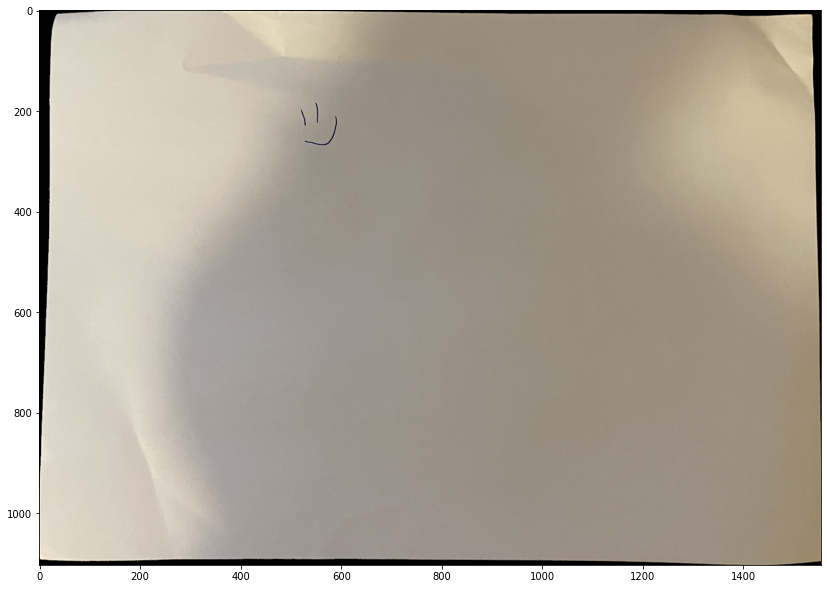

In [7]:
def getBounds(image, valid_pixels=3, step=2):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    lenx = img.shape[1]
    leny = img.shape[0]

    minx = maxx = lenx / 2
    miny = maxy = leny / 2

    valid_pixel_score = 255 * valid_pixels
    for x in range(1, lenx -1, step):
        for y in range(1, leny -1):
            if img[y][x] == 255:
                score = np.sum(img[y-1:y+1, x-1:x+1]) 

                if score > valid_pixel_score:
                    if x < minx: minx = x
                    if x > maxx: maxx = x
                    if y < miny: miny = y
                    if y > maxy: maxy = y
                    
    return minx, miny, maxx, maxy

x1, y1, x2, y2 = getBounds(mask)

cropped_image = image2[y1:y2, x1:x2]
showImage(cropped_image)

Lastly save the image.

In [8]:
cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGRA)
cv2.imwrite('cropped_example.png', cropped_image)

True